In [1]:
import pandas as pd
print(pd.__version__)

1.4.1


In [3]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
#values = dataset.values
values = dataset.to_numpy()

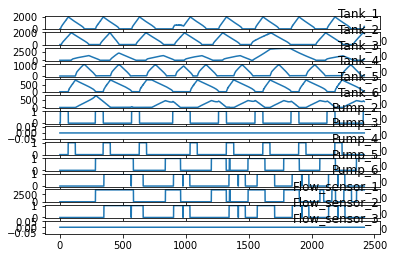

In [4]:

# specify columns to plot
#groups = [0, 1, 2, 3, 5, 6, 7]
#groups = [0, 1, 2, 3, 4, 5, 6]
groups = [0, 1, 2, 3, 4, 5,9,10,11,12,13,14,15,16]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Multivariate LSTM Forecast Model

In [5]:
from math import sqrt
from numpy import array
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 


In [6]:
values

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 332, 1845,  296, ...,    1,    0,    0],
       [ 358, 1833,  319, ...,    1,    0,    0],
       [ 409, 1815,  351, ...,    1,    0,    0]], dtype=int64)

   var1(t-1)  var42(t-1)  var1(t)  var2(t)   var3(t)  var4(t)  var5(t)  \
1        0.0         0.0      0.0      0.0  0.000000      0.0      0.0   
2        0.0         0.0      0.0      0.0  0.000000      0.0      0.0   
3        0.0         0.0      0.0      0.0  0.000000      0.0      0.0   
4        0.0         0.0      0.0      0.0  0.000000      0.0      0.0   
5        0.0         0.0      0.0      0.0  0.027273      0.0      0.0   

   var6(t)  var7(t)  var8(t)  ...  var33(t)  var34(t)  var35(t)  var36(t)  \
1      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0   
2      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0   
3      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0   
4      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0   
5      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0   

   var37(t)  var38(t)  var39(t)  var40(t)  var41(t)  var42(t)  
1       0.0       0.0       

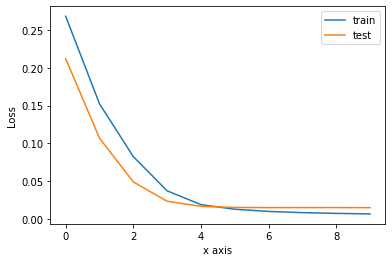

ValueError: operands could not be broadcast together with shapes (482,43) (42,) (482,43) 

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
n_train_hours = 1936
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.xlabel('x axis')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [21]:
# Test RMSE: 0.046

In [31]:
reframed.head()

,var39(t-1),var40(t-1),var41(t-1),var42(t-1),var43(t-1),var44(t-1),var45(t-1),var46(t-1),var1(t),var2(t),...,var37(t),var38(t),var39(t),var40(t),var41(t),var42(t),var43(t),var44(t),var45(t),var46(t)
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### USING OBJECT ORIENTATION

#### Functions:
###### Conversion of Sequence to supervised learning format

In [79]:
# convert sequence to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [80]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

In [81]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

In [82]:
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

### CPS Signal Generation Using LSTM

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load training data set from CSV file
training_data_df = pd.read_csv("phy_cps_train.csv", header=0, index_col=0)

# Load testing data set from CSV file
test_data_df = pd.read_csv("phy_cps_test.csv", header=0, index_col=0)

# Scale the data to a small range like 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both the training inputs and outputs
scaled_training = scaler.fit_transform(training_data_df)
scaled_testing = scaler.transform(test_data_df)

# Print out the adjustment that the scaler applied to the output column of data
print("Note: the output values were scaled by multiplying by {:.10f} and adding {:6f}".format(scaler.scale_[8], scaler.min_[8]))

# Create new pandas dataframe objects from the scaled data
scaled_training_df = pd.DataFrame(scaled_training, columns=training_data_df.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing, columns=test_data_df.columns.values)

# Save scaled data dataframes to new CSV files
scaled_training_df.to_csv("phy_cps_data_training_scaled.csv", index=False)
scaled_testing_df.to_csv("phy_cps_data_testing_scaled.csv", index=False)

Note: the output values were scaled by multiplying by 1.0000000000 and adding 0.000000
